In [ ]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [ ]:
import utils_generic as generic
import rrnn_modelo as rrnn

import train_datamaps as train 
from train import eval_func_multi

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']
model_name = 'rrnn'
num_labels = 2

# Datos ConvAI2

In [ ]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [ ]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [ ]:
convai_train_dataset =rrnn.DatasetMultiTaskRRNN(convai_train_token,tasks,eval=False)

In [ ]:
convai_val_dataset = rrnn.DatasetMultiTaskRRNN(convai_val_token,tasks,eval=False)

# Datos md_gender

In [ ]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [ ]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset  = rrnn.DatasetMultiTaskRRNN(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [ ]:
dl_train =  DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_multi)
dl_val = DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_multi)
dl_eval  = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_multi)

# MODELO

In [13]:
emb_dim = 100
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

In [ ]:
num_epochs = 100
learning_rate = 5e-5

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}


  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0754826774995916 	 Validation loss: 2.0785548646571272 	 
 50%|█████     | 574/1148 [00:21<00:21, 26.58it/s]
Epoch 2 	 Training loss: 2.0730605956154005 	 Validation loss: 2.078132851649139 	 
100%|██████████| 1148/1148 [00:42<00:00, 29.64it/s]


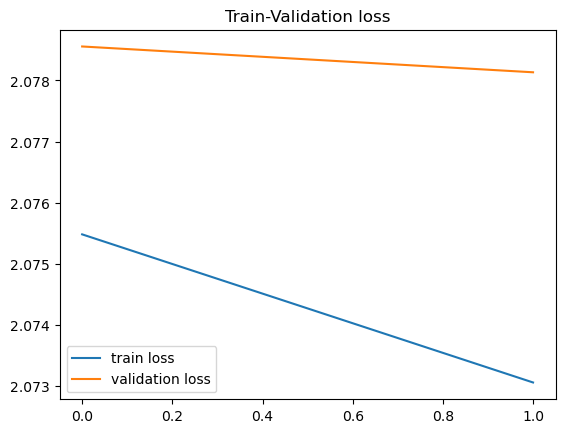

In [15]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
save_path=f'm1_{model_name}_1'
optimizer = AdamW(model.parameters(), lr=learning_rate)
p, c, e = train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)
torch.save(p,save_path+'_probs'+'.pt')
torch.save(c,save_path+'_corr'+'.pt')

In [ ]:
for task in ['about','as','to']:
    print(task.upper())
    train.get_datamap_complete_graph(p[task],correctness_vector=c[task],num_epochs=e)

In [17]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

metrics_results = eval_func_multi(model,dl_eval,['about','to','as'])
for task, task_metrics in metrics_results.items():
    print(f'Resultados en la tarea {task.upper()}:')
    for metric, value in task_metrics.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:

            for g,v in value.items():
                global_metrics[task][metric][g].append(v)
        print(metric,metrics_results[task][metric])
    print('\n')



Resultados en la tarea ABOUT:
recall {'female': 0.06, 'male': 0.9817708333333334, 'average': 0.5208854166666667}
precision {'female': 0.7741935483870968, 'male': 0.50066401062417, 'average': 0.6374287795056334}
f1 {'female': 0.111368909512761, 'male': 0.6631486367634124, 'average': 0.3872587731380867}
accuracy 0.5114795918367347


Resultados en la tarea TO:
recall {'female': 0.05249343832020997, 'male': 0.9537712895377128, 'average': 0.5031323639289614}
precision {'female': 0.5128205128205128, 'male': 0.5205843293492696, 'average': 0.5167024210848912}
f1 {'female': 0.09523809523809523, 'male': 0.6735395189003436, 'average': 0.3843888070692194}
accuracy 0.5202020202020202


Resultados en la tarea AS:
recall {'female': 0.05121293800539083, 'male': 0.9595959595959596, 'average': 0.5054044488006751}
precision {'female': 0.5428571428571428, 'male': 0.5191256830601093, 'average': 0.5309914129586261}
f1 {'female': 0.09359605911330049, 'male': 0.6737588652482269, 'average': 0.3836774621807637}

In [ ]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
save_path=f'm1_{model_name}_2'
optimizer = AdamW(model.parameters(), lr=learning_rate)
p, c, e = train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)
torch.save(p,save_path+'_probs'+'.pt')
torch.save(c,save_path+'_corr'+'.pt')

In [ ]:
for task in ['about','as','to']:
    print(task.upper())
    train.get_datamap_complete_graph(p[task],correctness_vector=c[task],num_epochs=e)

In [ ]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

metrics_results = eval_func_multi(model,dl_eval,['about','to','as'])
for task, task_metrics in metrics_results.items():
    print(f'Resultados en la tarea {task.upper()}:')
    for metric, value in task_metrics.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:

            for g,v in value.items():
                global_metrics[task][metric][g].append(v)
        print(metric,metrics_results[task][metric])
    print('\n')


In [ ]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
save_path=f'm1_{model_name}_3'
optimizer = AdamW(model.parameters(), lr=learning_rate)
p, c, e = train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)
torch.save(p,save_path+'_probs'+'.pt')
torch.save(c,save_path+'_corr'+'.pt')

In [ ]:
for task in ['about','as','to']:
    print(task.upper())
    train.get_datamap_complete_graph(p[task],correctness_vector=c[task],num_epochs=e)

In [ ]:
model = rrnn.MultiTaskRRNN(emb_dim=emb_dim,vocab_size=vocab_size,lstm_hidden_dim=lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

metrics_results = eval_func_multi(model,dl_eval,['about','to','as'])
for task, task_metrics in metrics_results.items():
    print(f'Resultados en la tarea {task.upper()}:')
    for metric, value in task_metrics.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:

            for g,v in value.items():
                global_metrics[task][metric][g].append(v)
        print(metric,metrics_results[task][metric])
    print('\n')


In [ ]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))